In [1]:
using Pkg
Pkg.activate(".")

using JLD2, Plots, Lux, QuadGK, ComponentArrays, PhasorNetworks

  Activating project at `~/code/phasor_julia`


# Load the test data

In [2]:
include("train_classifier.jl")
data_dir = "pixel_data/"
file_pairs = get_dataset(data_dir)

  Activating project at `~/code/phasor_julia`


10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [4]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [5]:
n_test = 10000

10000

In [6]:
q = q_test[:, :, :, 1:n_test]
yl = ylocal_test[1:n_test]
pt = pt_test[1:n_test];

# Load the trained networks

## Multilayer Perceptrons

In [7]:
ids = 43:48 |> collect;

In [8]:
function auroc(trained, call_fn)
    global pt
    pth = call_fn(trained)
    roc = tpr_fpr(pth, pt)
    roc_u = average_duplicate_knots(roc[2], roc[1])
    roc_fn = linear_interpolation(roc_u...)
    auroc = quadgk(roc_fn, 0.0, 1.0)[1]
    return auroc
end

auroc (generic function with 1 method)

In [9]:
mlps = [load("trained_nns/mlp_id_" * string(id) * "_epoch_100.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (scale = Float32[0.84043115, 1.2591363, 1.7509029, 1.6067656, 1.2224876, 1.183681, 1.3597107, 1.7909936, 1.9222077, 0.5121033, 0.35439044, 0.46825647, 0.15563248, 0.60759217], bias = Float32[-0.15679184, 0.007983687, 0.34967747, 0.5587814, 0.54680705, 0.6282297, 0.58878344, 0.371983, 0.020967497, -0.30517352, -0.24793093, -0.03700212, -0.32763767, 0.07363863]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.26534644 0.16762076 … 0.2233943 0.8040235; 0.114862956 0.055006634 … -0.1330096 -0.5745751; … ; -0.26862222 0.023581494 … -0.15008631 -0.49673986; -0.030385466 0.08127815 … -0.052740205 -0.410357], bias = Float32[0.11983151; 0.2736901; … ; 0.14855553; -0.056346085;;]), layer_4 = (weight = Float32[-0.91825676 -0.09599364 … -0.008247511 -0.18569079; 0.28259072 0.5849801 … 0.5030338 -0.36946005; 0.15059568 -0.26762253 … -0.3119786 0.25879323], bias = Float32[0.025180005; 0.09040724; -0.048583783;;])), "state" => (la

In [10]:
function predict_mlp(trained)
    params = trained["params"]
    state = trained["state"]
    global q
    global yl

    pred, _ = mlp_model(process_inputs_mlp(q, yl), params, state)
    return pred
end

predict_mlp (generic function with 1 method)

In [11]:
pth = predict_mlp(mlps[1])

3×10000 Matrix{Float64}:
 -1.03936  -1.2827    -1.36365   …  -1.17661   -1.94372   -0.867384
 -1.20626  -0.365469   1.2509        0.156264  -0.174552   0.85686
  1.5732    1.06693   -0.822588      1.63345    1.201      0.590607

In [12]:
auroc_mlp = x -> auroc(x, predict_mlp)

#67 (generic function with 1 method)

In [13]:
auroc_mlps = auroc_mlp.(mlps)

6-element Vector{Float64}:
 0.8619534200418385
 0.8643762766615558
 0.8537256897336294
 0.8663365019548579
 0.8657329658315501
 0.857021721103633

## Phasor MLPs

In [14]:
pmlps = [load("trained_nns/pmlp_id_" * string(id) * "_epoch_100.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (scale = Float32[0.4611713, 0.7945772, 1.0455916, 0.9466239, 0.9983645, 0.7986385, 1.0625937, 1.076156, 1.085038, 0.17968072, 0.21605618, 0.16161042, 0.089231364, 0.3393442], bias = Float32[-0.30808827, 0.103240624, 0.27551818, 0.5620901, 0.28622818, 0.5678, 0.15927714, 0.38617665, -0.0020063354, 0.12638877, -0.105870426, -0.116136976, 0.027554784, 0.33653456]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.05868069 -0.034977213 … 0.44358674 0.27405196; 0.10406588 0.0152126 … 0.019462781 -0.17392358; … ; -0.05868901 0.17384061 … 0.021038758 -0.031678833; -0.20989293 0.22455822 … -0.078325585 0.09693501], bias = ComplexF32[0.97786313f0 + 0.024052907f0im, 1.000072f0 + 0.0338428f0im, 0.89760166f0 + 0.086402066f0im, 0.98783225f0 - 0.013903405f0im, 1.0128567f0 + 0.009071913f0im, 0.96993476f0 - 0.11209156f0im, 0.9854144f0 + 0.08480665f0im, 1.0044348f0 + 0.0305721f0im, 1.0157015f0 + 0.0050732377f0im, 0.9813482f0 + 0.04

In [15]:
pmlps[1]["params"].layer_1

(scale = Float32[0.4611713, 0.7945772, 1.0455916, 0.9466239, 0.9983645, 0.7986385, 1.0625937, 1.076156, 1.085038, 0.17968072, 0.21605618, 0.16161042, 0.089231364, 0.3393442], bias = Float32[-0.30808827, 0.103240624, 0.27551818, 0.5620901, 0.28622818, 0.5678, 0.15927714, 0.38617665, -0.0020063354, 0.12638877, -0.105870426, -0.116136976, 0.027554784, 0.33653456])

In [16]:
function predict_pmlp(trained)
    params = trained["params"]
    state = Lux.testmode(trained["state"]) |> Lux.testmode
    global q
    global yl

    pred, _ = pmlp_model(process_inputs_pmlp(q, yl), params, state)
    return pred
end

predict_pmlp (generic function with 1 method)

In [17]:
auroc_pmlp = x -> auroc(x, predict_pmlp)

#71 (generic function with 1 method)

In [18]:
auroc_pmlps = auroc_pmlp.(pmlps)

6-element Vector{Float64}:
 0.8605830155809093
 0.8643945911370625
 0.8618744300514036
 0.8613199433241734
 0.8623075824633012
 0.8597111925094723

In [23]:
function eval_loss_pmlp(record)
    return loss_pmlp(q, yl, pt, pmlp_model, record["params"], record["state"], 0.2)[1]
end

eval_loss_pmlp (generic function with 1 method)

In [24]:
eval_loss_pmlp.(pmlps)

6-element Vector{Float64}:
 0.15535403007449292
 0.15257644900927525
 0.15455789819945703
 0.15456386720695137
 0.15440816298034946
 0.15573742640473287

In [20]:
loss_pmlp(q, yl, pt, pmlp_model, pmlps[1]["params"], pmlps[1]["state"], 0.2)

(0.15535403007449292, (layer_1 = (running_mean = [0.5575960337819733, 0.6709773805494152, 3.900619661795731, 16.582760998952132, 40.528143239484294, 46.551199900360345, 34.51181842470439, 11.710021084478301, 1.4615836243222227, 0.28752912785785484, 0.21368305428429898, 0.09681988792276322, 0.10840557794391252, 0.1393648519317953], running_var = [44.36869630827826, 29.620829631423234, 143.73697620154383, 798.1240736447626, 2777.980704661462, 2457.8730511989083, 2365.54637085704, 721.1127172161353, 92.51829070706248, 20.30936367261161, 11.586541204433338, 2.7789572372330733, 10.316794066084825, 20.015114414752453], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [25]:
lh = [0.5781010221248687
,0.6815230210484585
,0.5772793015051705
,0.6148226743179909
,0.5282999196027727
,0.5537947659624611
,0.5403303704235983
,0.5461157759542514
,0.5327561821024448
,0.4711647247604152
,0.41726354084143846
,0.3783660832115173
,0.36375562062268396
,0.25861534317387025
,0.2906042293298604
,0.2726772732600172
,0.24455319379561552
,0.26410199528160316
,0.2563394076923882
,0.2516529530069009
,0.246527004844096
,0.22533696367342457
,0.25105462554116587
,0.23669095160738188
,0.24806649283602952
,0.23998588167640555
,0.2437083327925195
,0.23425670402071608
,0.24583693083121247
,0.23237272453364963
,0.24199788145516585
,0.23124304386832975
,0.23013535265097992
,0.2355096571161801
,0.22112415701523674
,0.22322311657392965
,0.22008808680167158
,0.23045758148391732
,0.21071685766900053
,0.228049596298907
,0.21719384534842923
,0.2332858159562862
,0.22116686795990323
,0.2220690135224458
,0.2232556640831399
,0.21041807602230372
,0.22155850324750928
,0.2108002976638049
,0.22543350621026287
,0.20964562388269528
,0.21199105493057208
,0.21456242757171168
,0.21868687865184377
,0.23032815922817743
,0.22299487622302216
,0.2088993243635721
,0.22109678003902122
,0.21048961702397392
,0.2173296467892958
,0.2050203262541196
,0.21364173639790887
,0.2076596778307598
,0.21779014800700197
,0.21849049542702945
,0.2170188750978237
,0.1986084198844615
,0.22136959526303607
,0.19755801126287462
,0.21736396018495874
,0.20088333169855832
,0.22098698587258414
,0.20448600994981944
,0.22358463935911493
,0.21402646968726569
,0.19893406312383388
,0.21576144730957195
,0.20092120308328332
,0.2127807803121167
,0.2268252089062392
,0.19915078196736635
,0.2213250226777021
,0.2146529465303006
,0.20425921567886518
,0.21093900099343502
,0.20301004228429506
,0.23283276034785666
,0.2101382478553862
,0.19682108220348
,0.21720587214701012
,0.19680931003796331
,0.20415761473688665
,0.2252191230493486
,0.21467493568345256
,0.20593086258147655
,0.21085077476702202
,0.21347728384165116
,0.21019860614086433
,0.20654883060132026
,0.20338021843197504
,0.23643325963972342
,0.19704404186567845
,0.23120532942035096
,0.20693876339540312
,0.2285139312983782
,0.21915628150546143
,0.1962219122994289
,0.21314986307003153
,0.2100926262372513
,0.20437678715737584
,0.22509877168309655
,0.21630162592196636
,0.2096323007724831
,0.21755834125684734
,0.21266068145114936
,0.2042570315793155
,0.21571922396547982
,0.2154920641048516
,0.22128547793985281
,0.2025432202053309
,0.20021694294408554
,0.21808702056737433
,0.20105754447159574
,0.21770261881413433
,0.2107860754269912
,0.19609107066287346
,0.22391299745455637
,0.2092535786968411
,0.2172512511059889
,0.19811584462640972
,0.2219451433736654
,0.20067577926526722
,0.20145369107611585
,0.21578396343621287
,0.20018216873346062
,0.21004327332509576
,0.2129615532939177
,0.21728065852639133
,0.21984413696936067
,0.20331879319073104
,0.23826679249075558
,0.194276472060363
,0.21192335901742118
,0.21728534944419423
,0.20890772261017507
,0.22234511407587987
,0.20491124196728466
,0.20381997569443458
,0.2044029324632809
,0.21867308442737132
,0.2094534410914337
,0.20451348834373306
,0.23316239259943564
,0.19857109837309267
,0.2264611570493725
,0.20331164212336833
,0.223391369342297
,0.22217519457709747
,0.1980102568314175
,0.23961810263325542
,0.20921472822380452
,0.21798212273916762
,0.21058605996334792
,0.1981990359381133
,0.23288759623873828
,0.197938619268422
,0.21304021935106326
,0.20517817752482972
,0.21933709210152783
,0.20607261553022221
,0.21256718252721346
,0.20049999376274238
,0.21289752270213105
,0.2203640901018003
,0.2074681386134157
,0.23143108566691636
,0.1986351966601969
,0.2242710391437863
,0.20118651946069527
,0.2116322367373276
,0.20037417683195907
,0.21962919490503355
,0.20341999571962732
,0.20393894322582945
,0.2257510187679489
,0.21087594590118452
,0.20144734408141624
,0.21347435969968842
,0.2015403287956476
,0.2295275916214278
,0.19582552485589327
,0.2343401800168251
,0.19707055914613933
,0.24380971134845245
,0.2188647953955894
,0.19775214365340069
,0.20734338780964917
,0.2141191612357821
,0.21180100254869866
,0.21180619091070363
,0.21618791258055856
,0.21536454988500237
,0.20293056403877124
,0.2179107907264432
,0.19665152741097666
,0.22511625952227232
,0.2053744562888602
,0.22789017073337633
,0.20457845159905044
,0.2231123051896424
,0.19596413281924033
,0.226624698437786
,0.2053907751590652
,0.22935972468693866
,0.19642416980109595
,0.24751799158011503
,0.19642684471853042
,0.2327709743229117
,0.20534107836806892
,0.23203633969951243
,0.21824871049624403
,0.2063362851364831
,0.2176352350432709
,0.21412269474309406
,0.21559617167126405
,0.2106552225037416
,0.19684249956335342
,0.2280141622968284
,0.1966942101907603
,0.20515902565062216
,0.21701705333499768
,0.20579678872224708
,0.20749878613265726
,0.25004346029788804
,0.20373167833159858
,0.21320097844773056
,0.2142081406970431
,0.20518221594558192
,0.20670184810151368
,0.23028108818404835
,0.19590742901907637
,0.21216995112477077
,0.19895590723830928
,0.2171297073960659
,0.21438690013035205
,0.20225762371398592
,0.2356010063082181
,0.1972454037793949
,0.21116855157655737
,0.22126541753570536
,0.20178165994313724
,0.2106512512605156
,0.2056427160579139
,0.20206909155208957
,0.21808071267362947
,0.2136359850489612
,0.19686482883996442
,0.20027541577131727
,0.21262146980321955
,0.207377998378343
,0.21187987110990372
,0.20479710997653336
,0.200356551218598
,0.21796910176895387
,0.19727191897644525
,0.21468701790421724
,0.20354227906376604
,0.20544426897880777
,0.22099273242007672
,0.20711327636674015
,0.21189129660043798
,0.20263311548626
,0.22011890734614828
,0.19750312502284045
,0.21783478371301732
,0.21770413381315945
,0.19790862105975243
,0.23521310022950442
,0.2080247503038605
,0.22213197508577814
,0.20456947485956423
,0.20040638151911583
,0.22242864035805204
,0.20591191231579348
,0.21422496811182645
,0.19770409385180995
,0.21522525232722575
,0.218426008463285
,0.19534693900391373
,0.2074290460105056
,0.19834451380215193
,0.21119496099242732
,0.22468440828693337
,0.19813672016826
,0.21077266493519725
,0.1969699289787368
,0.22338682407759894
,0.2001610863172342
,0.21456363865794037
,0.22386565851375254
,0.21047172303137246
,0.19864816398234417
,0.21507895852184944
,0.21043328705607886
,0.2212827961940012
,0.21177083823040144
,0.2137319578905022
,0.2060600929578836
,0.21204794222678264
,0.20673954971633324
,0.239288898558671
,0.19689160361371458
,0.22644364494443167
,0.19598073456967038
,0.216498962466275
,0.21341311631182286
,0.21140544917642318
,0.21209211741626846
,0.20370837397805883
,0.20941431502820113
,0.21478949289908
,0.21077498011483828
,0.20036458687357117
,0.22220428550862137
,0.2135509751502299
,0.21266053555079162
,0.21430947870809028
,0.20604699428365467
,0.21853062473378068
,0.20154392818104067
,0.20895525681861102
,0.19583794714086256
,0.23553617909099886
,0.2032603667050524
,0.20567151018098526
,0.21480646556962543
,0.19759417678719007
,0.2311080379059688
,0.20630353378115146
,0.20858177501568956
,0.20752313635428227
,0.2087988154892103
,0.20332107706681996
,0.21495240828576018
,0.19786647438194405
,0.2184860291284569
,0.19810224973041407
,0.2265895767851016
,0.1986511300983384
,0.2199771923156147
,0.2035970967095017
,0.21258902675261473
,0.20371554818400045
,0.23040646237375034
,0.20346568019532946
,0.20376325937122186
,0.21604205627939804
,0.20645044076249155
,0.20688934586720714
,0.20154558311702386
,0.2182096216520784
,0.23503333052569397
,0.20597726765027463
,0.21550495195233738
,0.2240791849377906
,0.2156616367668244
,0.21122065661888284
,0.2215724405694922
,0.2045888461373003
,0.2047088999741764
,0.1970173377241241
,0.22422457381605818
,0.2025229266201656
,0.19869855510760365
,0.21943706859751727
,0.20185448528782554
,0.23445045880209442
,0.200523051136924
,0.2156691786746521
,0.2142884875326137
,0.22363741942832072
,0.1967421938053405
,0.2077695100360734
,0.19722049962765248
,0.2196811356438851
,0.2022172260973155
,0.19881612604583365
,0.21959929448644586
,0.20318986417560633
,0.20367452189836158
,0.22049376823184125
,0.2162970049230278
,0.20904771620860912
,0.20181190675768929
,0.21325716872293166
,0.20515036282789237
,0.22991845792516197
,0.19863109458539618
,0.23797834772385779
,0.20701380373561262
,0.21095958171371298
,0.19632116697224916
,0.19888991301879194
,0.21396330023656604
,0.208360571818936
,0.22553227389234182
,0.2005125492614749
,0.22244276106182778
,0.20511983951146104
,0.21984716289000752
,0.20699969931234302
,0.21720077795548867
,0.21113815561001126
,0.21162848355159794
,0.21190569030147477
,0.2060036285744488
,0.23190639622631043
,0.21262925313407333
,0.20210858473494697
,0.22609134326277472
,0.20043900661678118
,0.21846126409069755
,0.19712355171721072
,0.22585677627001555
,0.20678162336538713
,0.2004117339281264
,0.23306893209667223
,0.19678007581293397
,0.2203166336520957
,0.20075025367358315
,0.23613988972671335
,0.19587305430439492
,0.2227128070767751
,0.2035955880793801
,0.2241592288447207
,0.20557362944462257
,0.21486815117242755
,0.20822859768550314
,0.23011581844635154
,0.21294028985875338
,0.19566298266239968
,0.23156103097933933
,0.19641875487274243
,0.23946868882456238
,0.1964868193397234
,0.21681002596510107
,0.1961885508618912
,0.21952938563725138
,0.19622128367947436
,0.21568224933142652
,0.20576288225047798
,0.20028215145691491
,0.23379829845291167
,0.2136869038300361
,0.19641085655590088
,0.21803274990543353
,0.2041148429798666
,0.20868564556781577
,0.20285626540243584
,0.22764202386745291
,0.2030171872797828
,0.23609241972107906
,0.2077113342319426
,0.21259471640421274
,0.20348412658591172
,0.2333138303468406
,0.19732650210088873
,0.23836323173279672
,0.20100758891762163
,0.19754036808280467
,0.20747623810470392
,0.2250598746965653
,0.2153911992938784
,0.20273315622876137
,0.20831242934629293
,0.2144119648967519
,0.2079710824309337
,0.2156259091670097
,0.21052817651001457
,0.2250231708501262
,0.20975468083514054
,0.21472876852594874
,0.21518511781231367
,0.22799685367313074
,0.2016622757228403
,0.2117844625997189
,0.1987622052257503
,0.2283360809845544
,0.2165242010865518
,0.2016593744666092
,0.20725140340388204
,0.22100750584217535
,0.20472937583064288
,0.1955526531601342
,0.2204036825346317
,0.208664992241161
,0.21997091679095543
,0.2054834218870062
,0.2151725793639324
,0.22294091454137765
,0.19907919589114748
,0.21587088363267648
,0.20005908542542414
,0.2211759487004596
,0.2055619744764343
,0.21461601730191246
,0.20891111155334197
,0.20504398461844886
,0.21309454170643846
,0.2056975101322467
,0.2147191545206726
,0.20501603666612778
,0.22372001574072245
,0.19663858121164474
,0.24224103790845938
,0.19663737661458688
,0.21532256967460814
,0.20710839476605206
,0.21895344351611642
,0.19543930490837516
,0.2245282246719305
,0.19642634922174163
,0.21026298803323792
,0.20681745007290828
,0.2046059802187662
,0.2155674139392413
,0.20820325492635539
,0.21391364105901192
,0.20789058105987218
,0.219245591259138
,0.2229725881893699
,0.21981565410668308
,0.2097574954028481
,0.20432325752044764
,0.21850365299666702
,0.2010930008491731
,0.21470801018962993
,0.19522364914197193
,0.22535478343887191
,0.22023601095415968
,0.2118061367248735
,0.2136102161880186
,0.2096995399312641
,0.20626533604652392
,0.22698460458872946
,0.20028800092226687
,0.22342236299144075
,0.20012845767287543
,0.22432868014679275
,0.20423101882273093
,0.2184918491896542
,0.21373278509186716
,0.2162233497011794
,0.21063786862784856
,0.2028270827090973
,0.21849527527976484
,0.2036260001569247
,0.221773947641968
,0.21193607754639335
,0.21252995012336948
,0.2100057374302295
,0.21298573880883465
,0.2024196366495979
,0.2263261991629521
,0.21075992215407668
,0.20441005931328274
,0.21738503660845307
,0.20863486748151158
,0.20705607617189484
,0.19744051535178658
,0.21649580623733514
,0.1968563808950301
,0.21477615017085502
,0.20253269516088226
,0.23645207176020958
,0.19830029914591604
,0.22144931274066754
,0.2009778730559973
,0.2118859225395748
,0.20639503072586304
,0.20684702143467573
,0.2164950714418555
,0.1999591596731465
,0.20646076349800374
,0.22459414303503752
,0.20763539778970677
,0.20587673138462545
,0.2266827336615316
,0.19613306580428258
,0.21915045428697127
,0.20468886210346177
,0.21527615080986034
,0.2005347055383257
,0.2049623564760871
,0.21754438643509005
,0.21927701312483114
,0.19752001927697144
,0.22032332486252404
,0.1989437937398093
,0.20617947091188232
,0.20615237599475594
,0.19898846743168352
,0.2444282167507923
,0.19960195800613414
,0.22584101668605044
,0.2001249798153368
,0.21180244071898147
,0.2069546400919573
,0.2212167390339287
,0.19914008488251442
,0.21695266573903038
,0.22045072804160576
,0.19706152378209385
,0.21467841929104706
,0.2148744493609966
,0.2124149842684172
,0.2007149006312981
,0.23179217435864255
,0.20991139862339295
,0.2162132809083224
,0.20498130100614922
,0.2285102061264998
,0.19996005695870958
,0.22313506935420227
,0.20389479188222048
,0.2011601695922309
,0.2114609284274715
,0.2087250940697564
,0.23363311025392794
,0.1951364703990627
,0.2322014644032306
,0.20564082035925402
,0.21111033178614988
,0.20886164598418805
,0.22077724252991665
,0.19590426140633196
,0.2170629728311983
,0.19524514429239395
,0.22236916003944998
,0.19986417772202134
,0.23016154317517623
,0.21847138002503472
,0.1972683790519005
,0.21280881597209966
,0.21677886419420467
,0.2093342059723672
,0.20534072134809717
,0.2297291079417828
,0.19506906726060544
,0.2270618232261104
,0.20000224964060975
,0.20471712319744076
,0.2132079424947233
,0.20927228085175234
,0.23131940409611101
,0.20658900217487244
,0.2089860610968697
,0.21784942352848158
,0.20767950164807014
,0.22611255399384073
,0.20889268051212648
,0.20868350195826607
,0.21688921196134145
,0.20431573154587596
,0.2066763002217312
,0.21430707168526617
,0.22665882695147221
,0.1991309206878921
,0.2225941010763079
,0.19869689515825395
,0.1987723447694128
,0.2124148606484717
,0.22237094515140104
,0.19842515332394656
,0.22542691130098977
,0.19619628966110766
,0.20480726232564334
,0.2092339413147113
,0.21575667551248676
,0.20159224664256475
,0.22611412577309278
,0.19544089260628458
,0.23755944753884184
,0.2173604158290106
,0.20274738593685043
,0.21833643351208007
,0.21516446342573192
,0.21632897200467935
,0.19597466594291404
,0.21071923588258953
,0.19777125614526475
,0.21637038117447838
,0.2050419826953194
,0.2111936123046735
,0.21150457205698275
,0.2046085655410167
,0.21601771194367575
,0.21105092514246768
,0.19548014433391983
,0.22928878993234603
,0.20142639376364063
,0.21619485627298748
,0.20573735382854022
,0.21169959127485083
,0.215151513849353
,0.19570966130386974
,0.22280673798341807
,0.1957772405212521
,0.2152107164855691
,0.2236722585959976
,0.19779456348628316
,0.21974186362037826
,0.20193690422042238
,0.22314856910421915
,0.20557471205406683
,0.20337995360711103
,0.20919533016367214
,0.21710191244242505
,0.19839553603431875
,0.22331273786444117
,0.19820789953108933
,0.21324935136281783
,0.20703312550555159
,0.22705122778038736
,0.21937587019836727
,0.20388576372097647
,0.22209516451341513]

726-element Vector{Float64}:
 0.5781010221248687
 0.6815230210484585
 0.5772793015051705
 0.6148226743179909
 0.5282999196027727
 0.5537947659624611
 0.5403303704235983
 0.5461157759542514
 0.5327561821024448
 0.4711647247604152
 0.41726354084143846
 0.3783660832115173
 0.36375562062268396
 ⋮
 0.20337995360711103
 0.20919533016367214
 0.21710191244242505
 0.19839553603431875
 0.22331273786444117
 0.19820789953108933
 0.21324935136281783
 0.20703312550555159
 0.22705122778038736
 0.21937587019836727
 0.20388576372097647
 0.22209516451341513

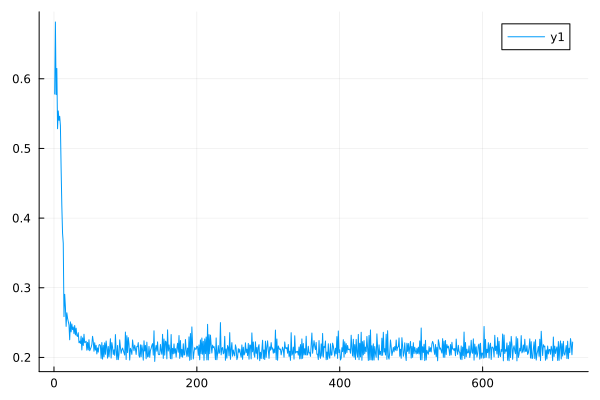

In [29]:
plot(lh)

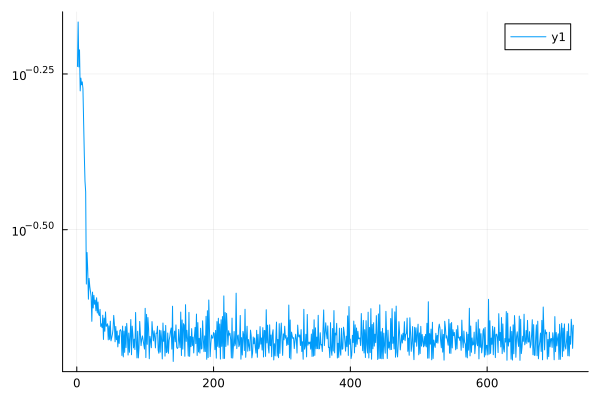

In [28]:
plot(lh, yscale=:log10)

In [18]:
repeats

20

In [19]:
function predict_pmlp_spk(trained)
    params = trained["params"] |> convert_pmlp_params
    state = trained["state"] |> Lux.testmode |> convert_pmlp_params 
    global q
    global yl

    train, _ = pmlp_model_spk(process_inputs_pmlp(q, yl), params, state)
    pred = train_to_phase(train)[end-1,:,:]
    return pred
end

predict_pmlp_spk (generic function with 1 method)

In [20]:
auroc_pmlp_spk = x -> auroc(x, predict_pmlp_spk)

#74 (generic function with 1 method)

In [21]:
auroc_pmlp_spks = auroc_pmlp_spk.(pmlps)

6-element Vector{Float64}:
 0.8602563581517786
 0.862289503431733
 0.8584875225677864
 0.8584793224462931
 0.8613515225015593
 0.859487520387155

In [22]:
auroc_pmlps .- auroc_pmlp_spks

6-element Vector{Float64}:
 0.0003266574291307389
 0.002105087705329467
 0.003386907483617252
 0.0028406208778802844
 0.0009560599617418619
 0.00022367212231722

In [23]:
using StatsPlots

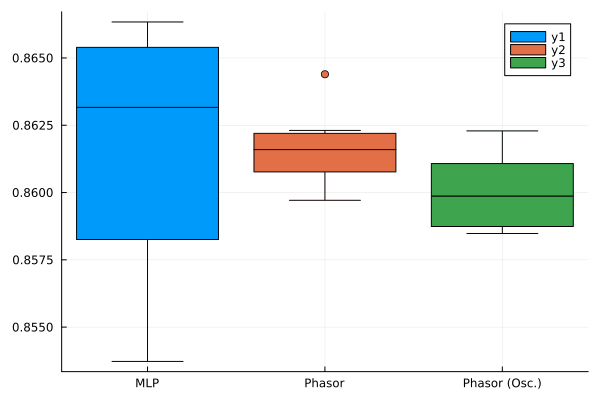

In [24]:
boxplot(stack((auroc_mlps, auroc_pmlps, auroc_pmlp_spks), dims=2))
xticks!([1.0, 2.0, 3.0], ["MLP", "Phasor", "Phasor (Osc.)"])

In [25]:
using HypothesisTests

In [26]:
MannWhitneyUTest(auroc_pmlps, auroc_pmlp_spks)

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.00172525

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1320

Details:
    number of observations in each group: [6, 6]
    Mann-Whitney-U statistic:             28.0
    rank sums:                            [49.0, 29.0]
    adjustment for ties:                  0.0


In [27]:
function predict_ode(trained)
    params = trained["params"]
    state = trained["state"]
    global q
    global yl
    x_tms = range(start=0.0, stop=1.0, length=size(q, 1)) |> collect
    sa = SpikingArgs()

    pred, _ = ode_model(process_inputs_ode(q, x_tms, yl, sa), params, state)
    return pred
end

predict_ode (generic function with 1 method)

In [28]:
auroc_ode = x -> auroc(x, predict_ode)

#76 (generic function with 1 method)

In [29]:
odes = [load("trained_nns/ode_id_" * string(id) * "_epoch_100.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (layer_1 = (scale = Float32[0.5355419, 0.6982475, 1.1660694, 0.8414003, 0.6907191, 0.69963336, 0.8056348, 1.2444569, 0.9820672, 0.51326776, 0.3376549, 0.203787, 0.20024703, 1.396189], bias = Float32[-0.046362977, 0.019495774, 0.038520116, 0.4472649, 0.40736058, -0.16248043, -0.09638586, 0.2790477, -0.064980365, -0.01898654, -0.3076137, -0.51615435, -0.3593432, -0.20246935]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.026519319 0.0025367395 … 0.15776274 0.22420433; 0.12915637 0.23942517 … 0.012422733 0.13288532; … ; -0.055402208 0.3991249 … -0.11317738 -0.08592525; -0.13373503 0.14865763 … 0.022444913 -0.13480264], bias = Float32[-0.081324; 0.22691543; … ; 0.0766491; -0.15538977;;])), layer_2 = Float32[], layer_3 = (weight = Float32[-0.2024508 -0.2463429 … -0.26188383 -0.20445359; -0.5395407 0.71579164 … -0.29579166 -0.5552426; 0.11988521 -0.044706948 … 0.31210658 0.3256998], bias_real = Float32[10.756406, 0.5117

In [30]:
auroc_odes = auroc_ode.(odes)

6-element Vector{Float64}:
 0.8565303402116241
 0.8574997719668821
 0.8555462326924702
 0.8551482698576797
 0.8560718452261529
 0.8528450413312252

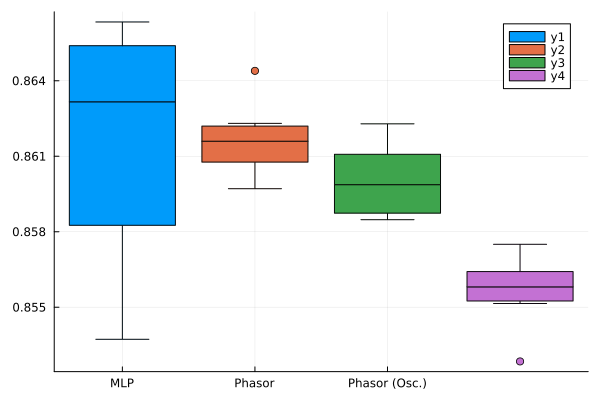

In [33]:
boxplot(stack((auroc_mlps, auroc_pmlps, auroc_pmlp_spks, auroc_odes), dims=2))
xticks!([1.0, 2.0, 3.0], ["MLP", "Phasor", "Phasor (Osc.)", "Phasor-ODE"])